In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import sys
import scipy.io
sys.path.append("..")
import ODE_Dynamics as od
import Test_Likelihood as tl
import Positive_Symptom_fn as fn

In [2]:
data = scipy.io.loadmat('../data/test_data_simulation.mat')
x = tf.cast(data['data_simulation'],dtype = tf.float32)
test_data = np.reshape(
      x, x.shape)

In [3]:
test_data = tf.transpose(test_data)
print(test_data)

tf.Tensor(
[[0.000e+00 1.060e+03 3.000e+00]
 [1.000e+00 1.062e+03 8.000e+00]
 [2.000e+00 1.037e+03 3.000e+00]
 [3.000e+00 9.970e+02 6.000e+00]
 [4.000e+00 9.850e+02 6.000e+00]
 [5.000e+00 9.920e+02 5.000e+00]
 [6.000e+00 9.670e+02 4.000e+00]
 [7.000e+00 1.068e+03 2.000e+00]
 [8.000e+00 1.060e+03 6.000e+00]
 [9.000e+00 1.011e+03 5.000e+00]
 [1.000e+01 1.049e+03 7.000e+00]
 [1.100e+01 1.001e+03 8.000e+00]
 [1.200e+01 9.740e+02 6.000e+00]
 [1.300e+01 9.500e+02 9.000e+00]
 [1.400e+01 9.470e+02 8.000e+00]
 [1.500e+01 9.740e+02 8.000e+00]
 [1.600e+01 1.003e+03 1.000e+01]
 [1.700e+01 1.028e+03 9.000e+00]
 [1.800e+01 1.014e+03 1.100e+01]
 [1.900e+01 1.026e+03 1.200e+01]
 [2.000e+01 9.730e+02 1.300e+01]
 [2.100e+01 1.036e+03 1.000e+01]
 [2.200e+01 1.016e+03 1.800e+01]
 [2.300e+01 1.023e+03 1.100e+01]
 [2.400e+01 1.002e+03 1.600e+01]
 [2.500e+01 1.056e+03 2.100e+01]
 [2.600e+01 9.940e+02 1.700e+01]
 [2.700e+01 1.115e+03 2.700e+01]
 [2.800e+01 1.010e+03 2.400e+01]
 [2.900e+01 1.020e+03 2.500e+01]

In [4]:
vdyn_ode_fn = od.ViralDynamics

In [5]:
positive_fn = fn.proba_pos_sym(170306.4 * 1E-5).positive_fn
symptom_fn = fn.proba_pos_sym(170306.4 * 1E-5).symptom_fn

In [6]:
prob_s_ibar = 0.1

In [7]:
loglike = tl.loglik(test_data, vdyn_ode_fn, positive_fn, symptom_fn, prob_s_ibar, prob_fp=0.0, Epi_Model=od.SIR,
                 duration= 20.0, Epi_cadence=0.5, Vir_cadence=0.0625)

In [8]:
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)
L = 0.0025/beta
V0 = np.random.normal(1E3, 1E2, 1)
print(V0)
X0 = 1E6
Y0 = V0
par=tf.constant(np.array([[L,0.01,beta*1E-7,0.5,20,10, V0, X0, Y0]], dtype=np.float32))
vpar = par
pospar = par
sympar = par

[1004.73752273]


In [9]:
sample_size = 1166
k = 1
index = 1
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
L = 0.0025/beta
par=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
V0 = np.random.normal(1E3, 1E2, 1)
X0 = 1E6
Y0 = V0
init_state=(np.array([[V0,X0,Y0]], dtype=np.float32))

while index <= sample_size - 1:
    beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
    L = 0.0025/beta
    par_new=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
    par = np.concatenate((par, par_new), axis = 0)
    V0 = np.random.normal(1E3, 1E2, 1)
    X0 = 1E6
    Y0 = V0
    init_state_new=(np.array([[V0,X0,Y0]], dtype=np.float32))
    init_state = np.concatenate((init_state, init_state_new), 0)

    index +=1
        

vpar = tf.constant(par, dtype=tf.float32)
pospar = par
sympar = par
print(par.shape)

(1166, 6)


In [10]:
epipar = tf.constant(np.array([[1.8,  5.0E-08,0.1, 0.001,0.999]], dtype=np.float32))

In [11]:
ll,pp = loglike.__call__(test_data,epipar, vpar, pospar, sympar)
print(pp)

initial time
0.0
final time
tf.Tensor(149.0, shape=(), dtype=float32)
tf.Tensor(
[ -40.811092  -57.8351    -20.685152  -37.459747  -36.72158   -31.61107
  -26.772562  -18.205477  -37.64897   -32.79648   -42.73052   -47.025017
  -38.092564  -51.31022   -47.25432   -48.065598  -57.305607  -54.1666
  -62.550995  -67.309425  -70.66769   -61.466286  -91.51869   -67.00939
  -85.33661  -105.29956   -90.57477  -129.26166  -116.47605  -121.14491
 -146.25232  -184.18939  -168.082    -176.42935  -160.63422  -179.0408
 -209.51773  -220.27473  -198.85678  -221.34595  -251.46286  -278.62265
 -289.5426   -282.196    -302.52267  -329.7228   -327.56177  -314.9437
 -355.71613  -364.31723  -393.24573  -399.9914   -433.1193   -429.43207
 -440.73566  -504.28253  -463.1983   -509.5913   -529.1098   -549.01
 -549.6577   -544.1974   -553.8013   -595.1582   -574.36707  -581.8197
 -626.6668   -637.37683  -617.8075   -655.9436   -678.3778   -660.24146
 -658.0028   -680.84393  -662.87616  -637.8211   -651.53564  

In [12]:
ll
C_xt = test_data[:,2]
N_xt = test_data[:,1]
pp_simu = C_xt/N_xt
print(pp_simu)

tf.Tensor(
[0.00283019 0.00753296 0.00289296 0.00601805 0.00609137 0.00504032
 0.0041365  0.00187266 0.00566038 0.0049456  0.00667302 0.00799201
 0.00616016 0.00947368 0.00844773 0.00821355 0.00997009 0.00875486
 0.01084813 0.01169591 0.01336074 0.00965251 0.01771654 0.01075269
 0.01596806 0.01988636 0.01710262 0.02421525 0.02376238 0.0245098
 0.02993452 0.0443787  0.03739214 0.04121688 0.03515625 0.04081633
 0.04623754 0.05059798 0.04442344 0.05164319 0.05840072 0.0637931
 0.06954225 0.06803939 0.07460035 0.08794197 0.0807993  0.07864165
 0.08271908 0.09700176 0.10677084 0.10720412 0.11725293 0.11416667
 0.1064996  0.13168086 0.12038523 0.13302398 0.1325391  0.14900154
 0.14534444 0.15263572 0.15212356 0.15445976 0.15037037 0.14793329
 0.17067833 0.16737589 0.17123796 0.17921147 0.17829993 0.1816224
 0.18142548 0.17849758 0.15692712 0.15843621 0.17546362 0.171875
 0.17879859 0.16441137 0.16014493 0.16280702 0.1536812  0.14799154
 0.16189812 0.14581844 0.13960114 0.14513889 0.1458037  

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
plt.style.use('ggplot')
font = {'size'   : 9}
plt.rc('font', **font)

Text(0.5, 1, 'Test-positive probability likelihood function')

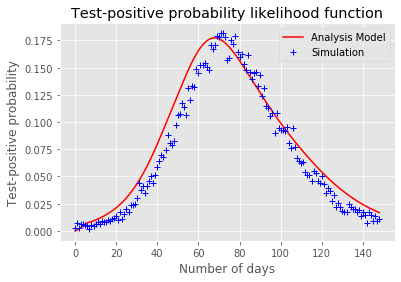

In [14]:
plt.plot(test_data[:,0], pp,"r-", label = "Analysis Model")
plt.plot(test_data[:,0], pp_simu, "b+", label = "Simulation")
plt.xlabel("Number of days")
plt.ylabel("Test-positive probability")
plt.legend(loc="upper right")
plt.savefig('simu_vs_code.pdf', dpi=300, bbox_inches='tight')
plt.title("Test-positive probability likelihood function")

In [14]:
prob_s_ibar = 0.1; prob_fp = 0.0
duration = 100; Epi_cadence = 0.5; Vir_cadence = 0.0625
vpar = tf.constant(np.array([[L,0.01,beta*1E-7,0.5,20,10, V0, X0, Y0]], dtype=np.float32))
pospar = vpar; sympar = vpar
loglike = tl.loglik(test_data, vdyn_ode_fn, positive_fn, symptom_fn, prob_s_ibar, prob_fp=0.0, Epi_Model=od.SIR,
                 duration= 20.0, Epi_cadence=0.5, Vir_cadence=0.0625)
ll,pp = loglike.__call__(test_data, epipar, vpar, pospar, sympar)

initial time
0.0
final time
tf.Tensor(149.0, shape=(), dtype=float32)


In [22]:
pp

<tf.Tensor: shape=(149,), dtype=float32, numpy=
array([-5.46141848e-07,  9.46962915e-04,  2.21096817e-03,  3.57615342e-03,
        5.05021634e-03,  6.64135581e-03,  8.35830998e-03,  1.02104014e-02,
        1.22075025e-02,  1.43601410e-02,  1.66794602e-02,  1.91772114e-02,
        2.18657721e-02,  2.47574914e-02,  2.78646667e-02,  3.12004220e-02,
        3.47787552e-02,  3.86145413e-02,  4.27233987e-02,  4.71217558e-02,
        5.18481880e-02,  5.60326912e-02,  6.02949224e-02,  6.48509264e-02,
        6.97170869e-02,  7.49098882e-02,  8.04457739e-02,  8.63408819e-02,
        9.26108435e-02,  9.92705151e-02,  1.06333740e-01,  1.13813080e-01,
        1.21719547e-01,  1.30062789e-01,  1.38850868e-01,  1.48089156e-01,
        1.57780096e-01,  1.67922974e-01,  1.78513691e-01,  1.89544693e-01,
        2.01004907e-01,  2.12872967e-01,  2.25110590e-01,  2.37682417e-01,
        2.50557840e-01,  2.63709158e-01,  2.77109355e-01,  2.90730983e-01,
        3.04544747e-01,  3.18518937e-01,  3.32618743

In [16]:
epipar

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[1.80e+00, 5.00e-08, 1.00e-01, 1.00e-03, 9.99e-01]], dtype=float32)>

In [17]:
vpar

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[3.7607492e-04, 9.9999998e-03, 6.6476116e-07, 5.0000000e-01,
        2.0000000e+01, 1.0000000e+01, 7.9532025e+02, 1.0000000e+06,
        7.9532025e+02]], dtype=float32)>

In [18]:
pospar

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[3.7607492e-04, 9.9999998e-03, 6.6476116e-07, 5.0000000e-01,
        2.0000000e+01, 1.0000000e+01, 7.9532025e+02, 1.0000000e+06,
        7.9532025e+02]], dtype=float32)>

In [19]:
sympar

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[3.7607492e-04, 9.9999998e-03, 6.6476116e-07, 5.0000000e-01,
        2.0000000e+01, 1.0000000e+01, 7.9532025e+02, 1.0000000e+06,
        7.9532025e+02]], dtype=float32)>